# Project : Donald Trump Bot
![alt text](https://github.com/QCaudron/ivanatrumpalot/raw/master/images/banner.jpg)

# Introduction

Make LSTM great again!

Long Short Term Memory neural networks are networks that have their own internal memory state. They process and remember information, which they have been fed with in a previous step. These information influence decisions later in the sequence.

In this work, Trump speeches are generated using former Trump speeches from 2016 to 2017 and Keras.

## Importations

The dataset was fortunately collected by somebody else (see https://www.kaggle.com/binksbiz/mrtrump) who collected them from subtitles of Youtube videos. We cannot be sure of the quality of the subtitles but what we saw by picking a random sample of theses speeches seemed to be correct. We cleaned the data and went through it to avoid special signs. The file will be uploaded here. 

### Import CSV file


In [1]:
from google.colab import files
uploaded = files.upload()

Saving MrTrumpSpeeches.csv to MrTrumpSpeeches.csv


### Import packages

In [2]:
#Basics importations

import numpy as np
import tensorflow as tf
from __future__ import division, print_function, unicode_literals
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import operator

#Keras importations

from keras.models import Sequential, model_from_json
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.utils  import np_utils
from keras.callbacks import ModelCheckpoint




# Import a stopword package and wordcloud package
!pip3 install nltk
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
!pip3 install wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# To make this notebook's output stable across runs

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

Using TensorFlow backend.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Transform the dataset in pandas format

In [3]:
#Open the CSV file, read it as dataframe object

df = pd.read_csv("MrTrumpSpeeches.csv", sep='delimiter', header=None)
df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


,0
0,id~playlist~upload_date~title~view_count~avera...
1,-2WTNSujhjk~Donald Trump Speeches & Events~201...
2,-64nfy6i58w~Donald Trump Speeches & Events~201...
3,-7Sp31hTxkU~Donald Trump Speeches & Events~201...
4,-byuyavcNI4~Donald Trump Speeches & Events~201...


Now, we need to use a better delimiter since the datafile is completly messed up.

In [40]:
#Change the separater, in order to read it

df = pd.read_csv("MrTrumpSpeeches.csv", sep='~', encoding='latin-1', dtype=str)
df.head()

,id,playlist,upload_date,title,view_count,average_rating,like_count,dislike_count,subtitles
0,-2WTNSujhjk,Donald Trump Speeches & Events,20160220,Live Stream: Donald Trump Victory Rally in Spa...,4057.0,4.25925922394,44.0,10.0,presidents of the United States mr. go tr...
1,-64nfy6i58w,Donald Trump Speeches & Events,20161107,LAST RALLY: Donald Trump FINAL CAMPAIGN Rally ...,47276.0,4.35802459717,952.0,182.0,it's now officially Tuesday November a di...
2,-7Sp31hTxkU,Donald Trump Speeches & Events,20160423,"FULL SPEECH: Donald Trump Rally in Bridgeport,...",19966.0,4.66666650772,220.0,20.0,you you I you the gre...
3,-byuyavcNI4,Donald Trump Speeches & Events,20160617,"Full Speech: Donald Trump Rally in Houston, Te...",15138.0,4.58249139786,266.0,31.0,we welcome stars and president all ov...
4,09BXh-AA72M,Donald Trump Speeches & Events,20161105,"Full Speech: Donald Trump Rally in Denver, Col...",8720.0,4.92473125458,365.0,7.0,you thank you great people Granna b...


This is better. The dataset seems more organized. However, we do not need all of the information but only the text parts right now

## Extract only the text parts of the speeches

In [43]:
#We don't select everything for the RNN

#Choose which speeches should be used for learning
#all speeches
#nb_speeches = 834 #Number of speeches : max = 834

#speeches for different periods
df = df.sort_values('upload_date')

#Changing the index with this new sorting

df = df.reset_index()

#Parameters

nb_speeches = 30  
start_RC = 0 #for republican campaign
start_PC = 171 #For Presidential campaign
start_P = 600 #for president

raw_text = df.subtitles[start_PC:(start_PC+nb_speeches)]


#make one large string out of all speaches
text = ""
for line in raw_text:
  text += " ".join(line.split())
  
print("Corpus length: {} ".format(len(text)))

Corpus length: 718767 


## Create mapping between char-int

In [44]:
chars = sorted(list(set(text))) #list of unique characters
len_chars = len(chars)

print("Number of chars: {}".format(len_chars))

#convert chars to numbers and back
char_to_int = dict((c, i) for i, c in enumerate(chars))
int_to_char = dict((i, c) for i, c in enumerate(chars))

Number of chars: 74


## Build sequences of the dataset which are used for prediction

Small sentences are used to be fed into the system for predicting the next character. This will then be added to the sequence until a speech is generated.

*Sentences* will include the training set inputs and *next_character* will include the outputs. *Seq_length *is determining the sequence length and *step* determines how far we move on in time when we pick a new sentence.


In [45]:
seq_length = 50
step = 3
sentences = []
next_character = []
for i in range(0, len(text) - seq_length, step):
    sentences.append(text[i : i + seq_length])
    next_character.append(text[i + seq_length])
print("Number of sentences from corpus {}".format(len(sentences)))

Number of sentences from corpus 239573


## Vectorization of the data

create multidimensional arrays for one-hot-encoding the input and decode the output

In [0]:
X = np.zeros((len(sentences), seq_length, len_chars), dtype=np.bool)
y = np.zeros((len(sentences), len_chars), dtype=np.bool)

for i, sentence in enumerate(sentences):
    for j, char in enumerate(sentence):
        X[i, j, char_to_int[char]] = 1
    y[i, char_to_int[next_character[i]]] = 1

# Statistical analysis of the dataset

First of all, we're going to sort the data according to the date. Then we want to classify the different videos and put them in different categories, according to the date of the speeches. In fact, a speech during the presidential campaign should be different from a speech made when Mr.Trump was president. For that, we need to use the "upload_date" column. Since the date is in a "American" format, which means YYYY/MM/DD, it's in an ascending order. Moreover, we need to convert the type, from string to an int.

In [0]:
type_upload = type(df.iloc[1]['upload_date'])
print(f'The type of upload_date is : {type_upload}')# For instance, we can see that the type is "string", we need to change that
df.size
df.head()

The type of upload_date is : <class 'str'>


,index,id,playlist,upload_date,title,view_count,average_rating,like_count,dislike_count,subtitles
0,504,6LBhZCoHXbg,Donald Trump Rally Speech Events Press Confere...,2014,Donald Trump John Kasich is just a STUBBORN gu...,4292.0,5.0,52.0,0.0,and what is he doing what is he doing rea...
1,794,WPnzNomBjuE,Donald Trump Rally Speech Events Press Confere...,20160201,LIVE Donald Trump Cedar Rapids Iowa Rally Doub...,1728.0,5.0,38.0,0.0,prism growing government and you know all...
2,831,ZqINGT-_Dno,Donald Trump Rally Speech Events Press Confere...,20160201,LIVE Donald Trump Rally in Waterloo Iowa on Ca...,8150.0,4.58620691299,130.0,15.0,time we've all worked very hard for this ...
3,652,KAMonkoVG4o,Donald Trump Rally Speech Events Press Confere...,20160202,LIVE Donald Trump Rally Milford New Hampshire ...,26696.0,4.73809528351,471.0,33.0,we love you we love you amazing it's amaz...
4,737,QpKhuMbYpm0,Donald Trump Rally Speech Events Press Confere...,20160205,LIVE Donald Trump Florence South Carolina Civi...,24555.0,4.74107122421,419.0,29.0,I was talking to somebody and then I talk...


## Plotting the number of speeches by period

In [0]:
# Sorting the dataset by upload_date

df = df.sort_values('upload_date')

# Converting the upload_date column in an numerical format

df.upload_date = df.upload_date.astype(int)

df = df.reset_index()


type_upload = type(df.iloc[1]['upload_date'])

print(f'The type of upload_date is : {type_upload}')



# Creating a new label for different periods of the Trump's speeches history
df['status'] = ""
status = ''
print(df.iloc[652]["upload_date"])
print(df.iloc[652]["upload_date"] <= np.int64(20170120))

for i in range(0,834):
    #print(type(df.iloc[i]["upload_date"]))
    tmp = df.iloc[i]["upload_date"]
    
    if (tmp <= 20160721) == True:
        df.set_value(i, 'status', "Republican campaign")
        
        
        
    elif (tmp >= np.int64(20160721) and tmp < np.int64(20161109)) == True:
        df.set_value(i, 'status', "Presidential campaign")
       
    elif (tmp >= np.int64(20161109) and tmp < np.int64(20170119)) ==  True:
        df.set_value(i, 'status', "Elected")
                
    elif (tmp == np.int64(20170120)) == True:
        df.set_value(i, 'status', "Inauguration Day")
        
    elif (tmp > np.int64(20170120)) == True:
        df.set_value(i, 'status', "President")
 
df.head(1000)

The type of upload_date is : <class 'numpy.int64'>
20170317
False


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


,level_0,index,id,playlist,upload_date,title,view_count,average_rating,like_count,dislike_count,subtitles,status
0,0,504,6LBhZCoHXbg,Donald Trump Rally Speech Events Press Confere...,2014,Donald Trump John Kasich is just a STUBBORN gu...,4292.0,5.0,52.0,0.0,and what is he doing what is he doing rea...,Republican campaign
1,1,794,WPnzNomBjuE,Donald Trump Rally Speech Events Press Confere...,20160201,LIVE Donald Trump Cedar Rapids Iowa Rally Doub...,1728.0,5.0,38.0,0.0,prism growing government and you know all...,Republican campaign
2,2,831,ZqINGT-_Dno,Donald Trump Rally Speech Events Press Confere...,20160201,LIVE Donald Trump Rally in Waterloo Iowa on Ca...,8150.0,4.58620691299,130.0,15.0,time we've all worked very hard for this ...,Republican campaign
3,3,652,KAMonkoVG4o,Donald Trump Rally Speech Events Press Confere...,20160202,LIVE Donald Trump Rally Milford New Hampshire ...,26696.0,4.73809528351,471.0,33.0,we love you we love you amazing it's amaz...,Republican campaign
4,4,737,QpKhuMbYpm0,Donald Trump Rally Speech Events Press Confere...,20160205,LIVE Donald Trump Florence South Carolina Civi...,24555.0,4.74107122421,419.0,29.0,I was talking to somebody and then I talk...,Republican campaign
5,5,596,fjPJ6c7J0tM,Donald Trump Rally Speech Events Press Confere...,20160207,LIVE Donald Trump Plymouth New Hampshire FULL ...,11145.0,4.79607820511,242.0,13.0,you you Wow this is beautiful we just k...,Republican campaign
6,6,92,JLZ8e4JYxe4,Donald Trump Speeches & Events,20160219,Full Speech: Donald Trump Rally in Pawley's Is...,1537.0,4.68421030045,35.0,3.0,you you thank you very much do you know...,Republican campaign
7,7,499,5qbCHV2KLLw,Donald Trump Rally Speech Events Press Confere...,20160220,LIVE Donald Trump Winning Speech Caucus South ...,11675.0,4.69230747223,168.0,14.0,everybody well I want to begin by thankin...,Republican campaign
8,8,0,-2WTNSujhjk,Donald Trump Speeches & Events,20160220,Live Stream: Donald Trump Victory Rally in Spa...,4057.0,4.25925922394,44.0,10.0,presidents of the United States mr. go tr...,Republican campaign
9,9,731,QAFYfsA28-Q,Donald Trump Rally Speech Events Press Confere...,20160221,LIVE Donald Trump Rally Georgia World Congress...,23641.0,4.79112291336,363.0,20.0,we love you we love you we had such an am...,Republican campaign


Now, we're gonna print the number of speeches according to the period :

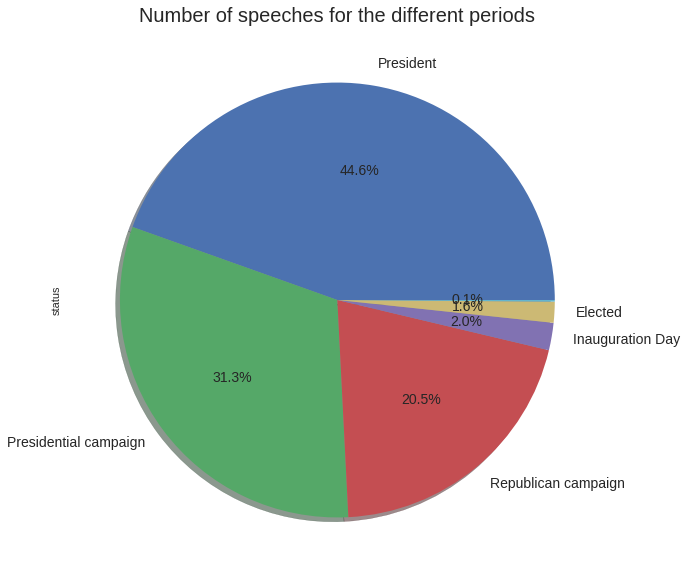

In [0]:
# Number of speeches by periods

s = df.groupby("id").status.agg(lambda x:x)

fig, axes = plt.subplots(ncols=1, figsize = (10,10))
pd.value_counts(s).plot(kind="pie",
                        ax = axes,
                        legend = False,
                        shadow = True, 
                        autopct='%1.1f%%',
                        fontsize=14,
                        title = "Number of speeches for the different periods")
axes.title.set_size(20)




Here we can see that most of the data we have is from the presidential campaign or after the election of Mr.Trump. We should then try to not mix theses different periods but rather to build our model on different times. This could show us if the speeches of Donald Trump have changed after his election for instance.

## The most used words

To understand the data, we need to know which words Donald Trump use the most. This could explain the results of our RNN. For instance, we can suppose that some words like "america" or "wall" should be very common.

In [0]:
counts = dict()
words = text.split()


#Counting the appearance of each word :

for word in words:
    if word in counts:
        counts[word] += 1
    else:
        counts[word] = 1

#Sorting the list of the words

sorted_counts = sorted(counts.items(), key=operator.itemgetter(1),reverse=True)

#Reversing the dictionnary, higher appearance should be first

sorted_counts2 = list(reversed(sorted_counts))

print(sorted_counts2)

[('you;;', 1), ('thriving', 1), ('lowered', 1), ('queening', 1), ('achatz', 1), ('indifferent', 1), ('funneled', 1), ('Kenya', 1), ('cashing', 1), ('cashed', 1), ('defender', 1), ('ginger', 1), ('fast-forward', 1), ('veil', 1), ('regarded', 1), ('destabilization', 1), ('negotiators', 1), ('charts', 1), ('shrink', 1), ('negotiates', 1), ('sheets', 1), ('approves', 1), ('740,000', 1), ('passage', 1), ('ram', 1), ('layoffs', 1), ('1,300', 1), ('fiat-chrysler', 1), ('ducking', 1), ('constructing', 1), ('1.6', 1), ('ford', 1), ('April', 1), ('2018', 1), ('motors', 1), ('manufacture', 1), ('revitalization', 1), ('preyed', 1), ('throwback', 1), ('conscience', 1), ('lifted', 1), ('afrin', 1), ('inner-city', 1), ('all-out', 1), ('Joyce', 1), ('item', 1), ('palaces', 1), ('african', 1), ('ninety-five', 1), ('requires', 1), ("Detroit's", 1), ('harmed', 1), ('cultures', 1), ('lean', 1), ('trapped', 1), ("family's", 1), ('unbeatable', 1), ('mourn', 1), ('dressed', 1), ('wage-earner', 1), ('specific

### Top words as a list

In [0]:
#Importing a stop words list from nltk package

stopWords = set(stopwords.words('english'))
print(stopWords)

#top_words function in order to use it for each period of the political career of Mr.Trump

def top_words(dictionnary):
    top = []
    
    for i in range(0,100):
      
        if dictionnary[i][0] not in stopWords:
          
            top.append(dictionnary[i])
            
            
        
    return(top)

  
#Do it for the sorted list

top_words(sorted_counts)
    


{'and', 'where', 'same', 'won', 'or', 'm', 'have', "hadn't", 'that', 'them', "she's", 'aren', 'myself', 'down', 'again', 'those', 'wasn', 'we', 'her', "mightn't", "didn't", 'ain', 'their', 'such', 'until', 'off', "haven't", 'with', 'theirs', 'you', 'in', 'than', "doesn't", 'after', 'most', 'all', 'd', "that'll", 'for', 'from', 'couldn', 'both', 'other', 'shan', 'she', 'how', 'on', 'which', 'i', 'my', 'didn', 'wouldn', 'being', "couldn't", 'against', 'its', 'a', 'was', 'doing', 'of', "needn't", 'mightn', 'his', 'nor', 'isn', 'ma', 'yours', 'whom', 'does', "you'll", 'into', 'been', 'y', 'above', "isn't", 'ourselves', 'is', 'had', 'just', 'an', "mustn't", 'why', 'o', 'now', 'few', "wasn't", 'hasn', 'over', 'it', 'the', 'at', 'him', 'these', 'our', 'did', 'more', 'they', 'out', 'am', 'to', 'this', 'will', "wouldn't", 'has', 'doesn', 't', 'weren', 'further', 'me', 'hers', "aren't", 'what', 'below', "shan't", 'during', 'having', 'hadn', 'should', 'yourselves', "should've", 'once', 'very', 'n

[('I', 4270),
 ('going', 2003),
 ('people', 1592),
 ('know', 1472),
 ("we're", 1179),
 ('said', 1120),
 ('right', 914),
 ('like', 839),
 ('great', 827),
 ('one', 767),
 ('country', 710),
 ("that's", 709),
 ('want', 681),
 ('get', 673),
 ('Hillary', 662),
 ("I'm", 645),
 ("they're", 604),
 ('say', 593),
 ('Trump', 581),
 ('think', 572),
 ('Clinton', 522),
 ('look', 499),
 ('good', 498),
 ('got', 471),
 ('way', 465),
 ('go', 465),
 ('make', 457),
 ('many', 448),
 ('would', 439),
 ('thank', 428),
 ('never', 418),
 ('okay', 414),
 ('lot', 408),
 ('see', 390)]

### Top words as a wordcloud

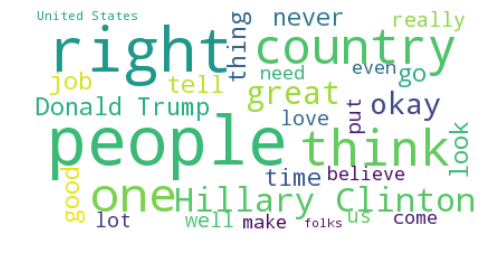

In [0]:
#Use a stop word list for wordcloud

stopwords = set(STOPWORDS)

#Add some other words that aren't interesting

stopwords.update(["going", "know", "way", "will","want","say", "said","see","got","mean","now"])


#Create the wordcloud and print it

wordcloud = WordCloud(stopwords=stopwords,max_font_size=60, max_words=30, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()



This is really interesting. This wordcloud will be very usefull for us in order to evaluate the validity of our model. In facts, our generated speeches must include these words because Donald Trump is very likely to use them. We can already see that some words are coherent with a political speech and even more with a Trump speech : "people", "United State", "country","work","Hillary Clinton" etc.

*** [BONUS] We could do it for each "period" : during the presidential election etc.

## [Bonus] Plot the number of like and dislike : estimation of popularity

Text(0, 0.5, 'Number of dislikes')

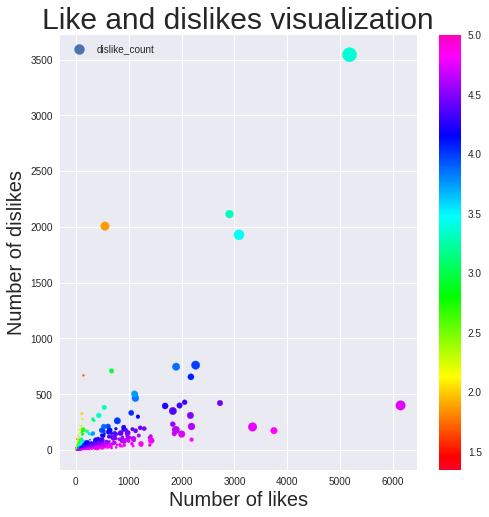

In [0]:
df.like_count = df.like_count.astype(float)
df.dislike_count = df.dislike_count.astype(float)
df.view_count = df.view_count.astype(float)


plt.figure(figsize=(8, 8))
ax = plt.scatter(df['like_count'], df['dislike_count'],c =df['average_rating'].astype(float), s = df['view_count']/5000,cmap='gist_rainbow')
plt.title("Like and dislikes visualization",fontsize = 30)
plt.colorbar(ax)
plt.legend()
plt.xlabel("Number of likes",fontsize = 20)
plt.ylabel("Number of dislikes",fontsize = 20)

Description of the figure : the colors corresponds to the "average_rating" column in our dataset. When it's red, that means a bad rate. However, when it's violet, it is a good rate, nearly 5/5. Moreover, the size of the bubble is proportionnal to the number of views of the speeches.

This figure gives us an interesting information : first of all, the speeches that were well rated are of course the one with more likes than dislikes. But the main information here is that Mr.Trump have more videos with many likes and few dislikes than the contrary. That means that his speeches can be considered as popular on the internet. This is coherent with the fact that Trump has based his campaign on his strange communication through his speeches.

# Build the RNN



## Complex Network

- four-layer LSTM network (quite complex)

- a dropout layer between each hidden layer

- 128--> 256 --> 512 --> 512 --> Dense Layer

- Use Adam_optimizer

- Use softmax activation*

In [10]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, init="glorot_uniform",
               input_shape=(seq_length, len_chars)))
model.add(Dropout(0.2))
model.add(LSTM(256, return_sequences=True, init="glorot_uniform"))
model.add(Dropout(0.2))
model.add(LSTM(512, return_sequences=True, init="glorot_uniform"))
model.add(Dropout(0.2))
model.add(LSTM(512, return_sequences=False, init="glorot_uniform"))
model.add(Dropout(0.2))
model.add(Dense(len_chars))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(128, return_sequences=True, input_shape=(50, 76), kernel_initializer="glorot_uniform")`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, return_sequences=True, kernel_initializer="glorot_uniform")`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(512, return_sequences=True, kernel_initializer="glorot_uniform")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(512, return_sequences=False, kernel_initializer="glorot_uniform")`
  if __name__ == '__main__':


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 50, 128)           104960    
_________________________________________________________________
dropout_5 (Dropout)          (None, 50, 128)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 50, 256)           394240    
_________________________________________________________________
dropout_6 (Dropout)          (None, 50, 256)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 50, 512)           1574912   
_________________________________________________________________
dropout_7 (Dropout)          (None, 50, 512)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 512)               2099200   
__________

## Simpler network
There were more than 4 million parameters in the first model thus try an easier network and compare

- One layer (128)
- Dense layer with softmax activation
- dropout

- categorical cross entropy with adam optimizer

In [0]:
model = Sequential()
model.add(LSTM(128, input_shape=(seq_length, len_chars)))
model.add(Dropout(0.2))
model.add(Dense(len_chars, activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer= 'adam', metrics= ['acc'])
model.summary()

Good, now it's only a little more than 100.000 parameters. But is it sufficient to get a speech that makes sense?

## Train the Model and get Parameters
![alt text](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQhW26L7438ZSXWKwWBgSn_lCxe_wsx-y6MmFm67UaBIKO1Dzez)

In [11]:
import sys

#Use softmax temperature function to predict next character
def sample(preds, temp=0.3):
  preds = np.asarray(preds).astype('float64')
  preds = np.log(preds) / temp
  exp_preds = np.exp(preds)
  preds = exp_preds / np.sum(exp_preds)
  probas = np.random.multinomial(1, preds, 1)
  return np.argmax(probas)

# Use n iterations since the model is quite complex
for iteration in range(1, 4):
    print("\n" + "-" * 50)
    print("Iteration {}".format(iteration))

    # Train the model for five epochs
    model.fit(X, y, batch_size=128, epochs=5, shuffle=True)

    
    # Pick a random part of the text to use as a prompt
    start_index = np.random.randint(0, len(text) - seq_length - 1)

    # Try out various energies in the probability distribution,
    # create some 200-character sample strings
    for diversity in [0.2, 0.5, 1.0]:
      print("\n-- Diversity : {}".format(diversity))
  
      generated = ""
      sentence = text[start_index : start_index + seq_length]
      generated += sentence
      print("-- Generating with prompt : \n {} ".format(sentence))
      sys.stdout.write(generated)

      # Generate 100 characters
      for i in range(100):
          #one-hot encode the generated characters
          sampled = np.zeros((1, seq_length, len_chars))
      
          for t, char in enumerate(sentence):
              sampled[0, t, char_to_int[char]] = 1.

          #predict next char and add it
          predictions = model.predict(sampled, verbose=0)[0]
          next_index = sample(predictions, diversity)
          next_char = chars[next_index]

          generated += next_char
          sentence = sentence[1:] + next_char

          sys.stdout.write(next_char)
          sys.stdout.flush()

    #save the output
    f= open("learn_speech.txt","w+")
    f.write("Iteration %d\n" % iteration)
    f.write(generated)
    
f.close()


--------------------------------------------------
Iteration 1
Epoch 1/5
 21248/385762 [>.............................] - ETA: 25:55 - loss: 3.0221

KeyboardInterrupt: ignored

In [0]:
files.download("learn_speech.txt")

## Produce a new speech

In [12]:
diversity = 0.3
# Pick a random part of the text to use as a prompt
start_index = np.random.randint(0, len(text) - seq_length - 1)
sentence = text[start_index : start_index + seq_length]

#produce a speech with n letters
for i in range(1000):
      #one-hot encode the generated characters
      sampled = np.zeros((1, seq_length, len_chars))
      
      for t, char in enumerate(sentence):
          sampled[0, t, char_to_int[char]] = 1.

      #predict next char and add it
      predictions = model.predict(sampled, verbose=0)[0]
      next_index = sample(predictions, diversity)
      next_char = chars[next_index]

      generated += next_char
      sentence = sentence[1:] + next_char

      sys.stdout.write(next_char)
print("\n")

NameError: ignored

## Save network

In [0]:
#save the weights
model.save_weights('model_weightsCompPres.h5')

#save model architecture
with open('model_architectureCompPres.json', 'w') as f:
    f.write(model.to_json())

files.download('model_weightsCompPres.h5')
files.download('model_architectureCompPres.json')

NameError: ignored

# Produce your own Trump Speech
![alt text](https://pbs.twimg.com/profile_images/862049261344653312/W_Sq0iH6_400x400.jpg)

## And if you want to use the model afterwards use either:

### 1) Simple Model:
Not so good results for the speech but fast

In [0]:
print("Load files model_architectureRep.json and model_weightsRep.h5 \n")

from google.colab import files
uploaded = files.upload()

from keras.models import model_from_json

### Load Model
# Model reconstruction from JSON file
with open('model_architectureRep.json', 'r') as f:
    model = model_from_json(f.read())

# Load weights into the new model
model.load_weights('model_weightsRep.h5')

#Prepare data
#Parameters
nb_speeches = 30
raw_text = df.subtitles[0:nb_speeches]

#make one large string out of all speaches
text = ""
for line in raw_text:
  text += " ".join(line.split())
  
chars = sorted(list(set(text))) #list of unique characters
len_chars = len(chars)
#convert chars to numbers
char_to_int = dict((c, i) for i, c in enumerate(chars))

### 2) Complex Model:
Better results for the speech

In [47]:
print("Load files model_architecturePres2.json and model_weightsPres2.h5 \n")
from google.colab import files
uploaded = files.upload()

from keras.models import model_from_json

### Load Model
# Model reconstruction from JSON file
with open('model_architecturePres2.json', 'r') as f:
    model = model_from_json(f.read())

# Load weights into the new model
model.load_weights('model_weightsPres2.h5')

#Prepare data
#Parameters
nb_speeches = 30  
raw_text = df.subtitles[171:(171+nb_speeches)]

#make one large string out of all speaches
text = ""
for line in raw_text:
  text += " ".join(line.split())
  
chars = sorted(list(set(text))) #list of unique characters
len_chars = len(chars)
#convert chars to numbers
char_to_int = dict((c, i) for i, c in enumerate(chars))

Load files model_architecturePres2.json and model_weightsPres2.h5 



Saving model_architecturePres2.json to model_architecturePres2 (3).json
Saving model_weightsPres2.h5 to model_weightsPres2 (3).h5


### Produce the Speech

In [48]:
#PRODUCE SPEECH
#length of speech:
length = 500 
diversity = 0.35

# Pick a random part of the text to use as a prompt
start_index = np.random.randint(0, len(text) - seq_length - 1)

generated = ""
sentence = text[start_index : start_index + seq_length]
generated += sentence

#produce a speech with n letters
for i in range(length):
      sampled = np.zeros((1, seq_length, len_chars))
      
      for t, char in enumerate(sentence):
          sampled[0, t, char_to_int[char]] = 1.

      #predict next char and add it
      predictions = model.predict(sampled, verbose=0)[0]
      next_index = sample(predictions, diversity)
      next_char = chars[next_index]

      generated += next_char
      sentence = sentence[1:] + next_char

      sys.stdout.write(next_char)        

e cares the people and they said it's the borders and they lat a big because they said the second because they were a policies and they said the state that the world people the me and they're going 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


to be the world all of the state that we want to be the way a few of the people it was the people to country and they don't know what what happened that's what have a movement we're going to have a tax in the lise they said the world we have a secret of the country and they want to do I was the people that and they want to take the business of the second the really so many the world that you know the because we're going to be a couple what it's heard the world and they were the world the person and I think you know what we don't know they said the the people that have to be the world so in the secret in the room it's all of the meaning and they said it's a couple and they don't know what we want to be a room and the million and you know what they can't have to do it the stories and they want